In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn
import os
import io
import math
from scipy.optimize import curve_fit

In [ ]:
sqs = 0.258265528440037
sqs25=0.181839887534859
sqs26=0.134725276024954

In [ ]:
data = pd.read_csv(f"/home/ilya/soft/lattice/general_code/tests/cpu/code/SA_test",header=0, names=["temperature", 'functional'])

print(data)

fg = seaborn.FacetGrid(data=data, height=5, aspect=1.61)
fg.map(plt.errorbar, 'temperature', 'functional', marker="o", fmt='', linestyle = '').add_legend()
plt.show()


In [ ]:
df_test = pd.DataFrame(
    {
        "b": [3, 3, 2, 2],
        "c": [7.9, 7.5, 9.9, 1.6],
        "d": [5.6, 5.6, 2.7, 2.7]
    }
)
print(df_test)

df_test = df_test.groupby(['b'])['c', 'd'].agg(np.mean).reset_index()

print(df_test)

In [57]:
#functions for reading data files

def get_size(str):
    str_tmp = str[str.find('=') + 1:].strip()
    time_size = int(str_tmp[0])
    str_tmp = str_tmp[str_tmp.find('=') + 1:].strip()
    space_size = int(str_tmp[0])

    return time_size, space_size

def remove_spaces(line):
    line_tmp = line.strip()
    result = ''
    while line_tmp.find(' ') != -1:
        result += line_tmp[0:line_tmp.find(' ')] + ','
        line_tmp = line_tmp[line_tmp.find(' '):]
        line_tmp = line_tmp.lstrip()

    result += line_tmp

    return result

def remove_spaces_and_first_number(line):
    line_tmp = line.strip()
    line_tmp = line_tmp[1:]
    line_tmp = line_tmp.lstrip()
    result = ''
    while line_tmp.find(' ') != -1:
        result += line_tmp[0:line_tmp.find(' ')] + ','
        line_tmp = line_tmp[line_tmp.find(' '):]
        line_tmp = line_tmp.lstrip()

    result += line_tmp

    return result

def read_file_vitaliy(file_path, func, field_type, field_coord):
    if(os.path.isfile(file_path)):
        df = []
        with open(file_path, 'r') as f:
            lines = f.readlines()

            data = []
            for i in range(len(lines)):
                line = lines[i].strip()
                if len(line) != 0:
                    if (line)[0] == '#':
                        if len(data) > 0:
                            df.append(pd.read_csv(io.StringIO('\n'.join(data)), names=[field_coord, f"field_action_{field_type}", f"err_action_{field_type}"], engine='python'))
                            # df[-1]['T'] = sizes[0]
                            df[-1]['R'] = sizes[1]
                            df[-1][field_coord] = df[-1][field_coord] - (4 + sizes[1] / 2)
                        data = []
                        sizes = get_size(line)

                    else:
                        data.append(func(lines[i]))

            df.append(pd.read_csv(io.StringIO('\n'.join(data)), names=[field_coord, f"field_action_{field_type}", f"err_action_{field_type}"], engine='python'))
            # df[-1]['T'] = sizes[0]
            df[-1]['R'] = sizes[1]
            df[-1][field_coord] = df[-1][field_coord] - (4 + sizes[1] / 2)

            df = pd.concat(df)

            return df

def concat_betas(betas, name, func):
    data = []
    for beta in betas:
        data.append(read_file_vitaliy(beta[0], name, func))
        data[-1]['beta'] = beta[0]
        data[-1]['field'] = data[-1]['field'] / beta[1]**2
        data[-1]['err'] = data[-1]['err'] / beta[1]**2
        data[-1]['d'] = data[-1]['d'] * math.sqrt(beta[1])

    return pd.concat(data)

def read_data_qc2dstag_decomposition(path, params, flux_coord, sigma):
    data = []
    for key, value in params.items():
        # print(value)
        data.append(pd.read_csv(f"{path}/flux_tube_su2-{key}.csv", index_col=None))
        data[-1] = data[-1].rename(columns={'field_electric': f'field_electric_{key}', 'err_electric': f'err_electric_{key}', 
                                            'field_magnetic': f'field_magnetic_{key}', 'err_magnetic': f'err_magnetic_{key}', 
                                            'field_energy': f'field_energy_{key}', 'err_energy': f'err_energy_{key}', 
                                            'field_action': f'field_action_{key}', 'err_action': f'err_action_{key}'})
        data[-1] = data[-1][data[-1]['T'] == value]
        data[-1] = data[-1].drop(['T'], axis = 1).reset_index()
        data[-1][flux_coord] = data[-1][flux_coord] * math.sqrt(sigma)
        data[-1][f"field_electric_{key}"] = data[-1][f"field_electric_{key}"] / sigma**2
        data[-1][f"field_magnetic_{key}"] = data[-1][f"field_magnetic_{key}"] / sigma**2
        data[-1][f"field_energy_{key}"] = data[-1][f"field_energy_{key}"] / sigma**2
        data[-1][f"field_action_{key}"] = data[-1][f"field_action_{key}"] / sigma**2
        data[-1][f"err_electric_{key}"] = data[-1][f"err_electric_{key}"] / sigma**2
        data[-1][f"err_magnetic_{key}"] = data[-1][f"err_magnetic_{key}"] / sigma**2
        data[-1][f"err_energy_{key}"] = data[-1][f"err_energy_{key}"] / sigma**2
        data[-1][f"err_action_{key}"] = data[-1][f"err_action_{key}"] / sigma**2
    data = pd.concat(data, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]
    data = data.drop(['index'], axis = 1)

    return data

def read_data_beta():
    data = []
    # data.append(concat_betas(betas, f'act-lng-prof0{direction}.dat', func))
    data.append(pd.read_csv(f"../result/flux_tube_wilson/su2_suzuki/24^4/flux_tube_electric_mu=0.00.csv", index_col=None))
    data[-1] = data[-1].rename(columns={'field': 'field_su2', 'err': 'err_su2'})
    data[-1]['beta'] = 2.4
    data[-1] = data[-1][data[-1]['T'] == 4]
    data[-1] = data[-1][data[-1]['R'] == 6]
    data[-1] = data[-1].drop(['T'], axis = 1).reset_index()
    # data.append(concat_betas(betas, f'act-lng-prof0{direction}_mon.dat', func))
    data.append(pd.read_csv(f"../result/flux_tube_wilson/monopole/su2_suzuki/24^4/flux_tube_electric_mu=0.00.csv", index_col=None))
    data[-1] = data[-1].rename(columns={'field': 'field_mon', 'err': 'err_mon'})
    data[-1]['beta'] = 2.4
    data[-1] = data[-1][data[-1]['T'] == 6]
    data[-1] = data[-1][data[-1]['R'] == 6]
    data[-1] = data[-1].drop(['T'], axis = 1).reset_index()
    # data.append(concat_betas(betas, f'act-lng-prof0{direction}-off.dat', func))
    data.append(pd.read_csv(f"../result/flux_tube_wilson/monopoless/su2_suzuki/24^4/flux_tube_electric_mu=0.00.csv", index_col=None))
    data[-1] = data[-1].rename(columns={'field': 'field_nomon', 'err': 'err_nomon'})
    data[-1]['beta'] = 2.4
    data[-1] = data[-1][data[-1]['T'] == 4]
    data[-1] = data[-1][data[-1]['R'] == 6]
    data[-1] = data[-1].drop(['T'], axis = 1).reset_index()


In [48]:
read_data_qc2dstag_decomposition('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6/HYP1_alpha=1_1_0.5_APE100_alpha=0.5', {'su2': 6}, 'd', 0.258265528440037)

,R,d,field_electric_su2,err_electric_su2,field_magnetic_su2,err_magnetic_su2,field_energy_su2,err_energy_su2,field_action_su2,err_action_su2
0,4,-3.557388,0.000062,0.000165,0.000081,0.000198,-0.000018,0.000208,0.000143,0.000299
1,4,-3.049190,0.000089,0.000188,0.000044,0.000186,0.000046,0.000201,0.000133,0.000315
2,4,-2.540992,0.000203,0.000185,0.000309,0.000200,-0.000106,0.000205,0.000511,0.000326
3,4,-2.032793,0.000737,0.000174,0.000934,0.000199,-0.000197,0.000202,0.001671,0.000314
4,4,-1.524595,0.002812,0.000200,0.002123,0.000203,0.000690,0.000229,0.004935,0.000331
...,...,...,...,...,...,...,...,...,...,...
90,12,3.557388,0.002080,0.000722,0.001056,0.000788,0.001024,0.000914,0.003136,0.001204
91,12,4.065587,-0.000205,0.000804,-0.000157,0.000772,-0.000048,0.000871,-0.000361,0.001312
92,12,4.573785,-0.000480,0.000823,-0.000491,0.000807,0.000012,0.000916,-0.000971,0.001349
93,12,5.081983,-0.000961,0.000815,-0.000406,0.000901,-0.000555,0.000985,-0.001367,0.001408


In [58]:
read_file_vitaliy('../result/flux_tube_wilson/vitaliy/beta2.4/act-lng-prof0.dat', remove_spaces, 'su2', 'd')

,d,field_action_su2,err_action_su2,R
0,-6.0,0.000248,0.000364,6
1,-5.0,0.001089,0.000384,6
2,-4.0,0.008530,0.000394,6
3,-3.0,0.022930,0.000405,6
4,-2.0,0.018800,0.000409,6
5,-1.0,0.007223,0.000417,6
6,0.0,0.006419,0.000505,6
7,1.0,0.007223,0.000417,6
8,2.0,0.018800,0.000409,6
9,3.0,0.022930,0.000405,6


In [59]:
read_file_vitaliy('../result/flux_tube_wilson/vitaliy/beta2.4/act-lng-prof0-tr.dat', remove_spaces_and_first_number, 'su2', 'x_tr')

,x_tr,field_action_su2,err_action_su2,R
0,-6.0,0.000183,0.000235,6
1,-5.0,0.000891,0.000295,6
2,-4.0,0.001172,0.000265,6
3,-3.0,0.002400,0.000314,6
4,-2.0,0.005138,0.000315,6
5,-1.0,0.006419,0.000505,6
6,0.0,0.005138,0.000315,6
7,1.0,0.002400,0.000314,6
8,2.0,0.001172,0.000265,6
9,3.0,0.000891,0.000295,6


In [37]:
def save_image(image_path, image_name, fg):
    try:
        os.makedirs(image_path)
    except:
        pass
    
    output_path = f'{image_path}/{image_name}'
    fg.savefig(output_path, dpi=400)

def join_back(data, flux_coord, matrix_types, columns):
    data1 = []
    for matrix_type in matrix_types:
        for field_type in ['electric', 'magnetic', 'energy', 'action']:
            data1.append(data[[flux_coord, 'R', f'field_{field_type}_{matrix_type}', f'err_{field_type}_{matrix_type}'] + columns])
            data1[-1] = data1[-1].rename(columns={f'field_{field_type}_{matrix_type}': 'field', f'err_{field_type}_{matrix_type}': 'err'})
            data1[-1]['matrix_type'] = matrix_type
            data1[-1]['field_type'] = field_type

    return pd.concat(data1)

def find_sum(data):
    for flux_type in ['electric', 'magnetic', 'energy', 'action']:
        data[f'err_{flux_type}_mon+nomon'] = data.apply(lambda x: math.sqrt(x[f'err_{flux_type}_monopole'] ** 2 + x[f'err_{flux_type}_monopoless'] ** 2), axis = 1)
        data[f'field_{flux_type}_mon+nomon'] = data.apply(lambda x: x[f'field_{flux_type}_monopole'] + x[f'field_{flux_type}_monopoless'], axis = 1)

    return data

def plot_action(data, flux_coord, image_path):
    R = data['R'].iloc[0]
    field_type = data['field_type'].iloc[0]
    print('R = ', R)
    fg = seaborn.FacetGrid(data=data, hue = 'matrix_type', height=5, aspect=1.61, hue_kws={"ls" : ['-', '', '', '-']})
    fg.fig.suptitle(f'{field_type}, R = {R}')
    fg.map(plt.errorbar, flux_coord, 'field', 'err', mfc=None, fmt='o', ms = 3, capsize = 5, lw = 0.5
    ).add_legend()
    fg.ax.set_xlabel(r"d$\sqrt{\sigma}$")
    fg.ax.set_ylabel(r"A/$\sigma^{2}$")

    plt.show()
    save_image(f'{image_path}', f'flux_tube_{field_type}_R={R}', fg)

def plot_action_long(direction, path, params, flux_coord, image_path, sigma):
    data = read_data_qc2dstag_decomposition(path, params, flux_coord, sigma)

    # data = pd.concat(data, axis = 1)
    # data = data.loc[:,~data.columns.duplicated()]
    # data = data.drop(['index'], axis = 1)

    # print(data)

    data = find_sum(data)

    # print(data)

    data = join_back(data, flux_coord, ['su2', 'monopole', 'monopoless', 'mon+nomon'], [])

    # print(data)

    data.groupby(['R', 'field_type']).apply(plot_action, flux_coord, image_path)

def get_flux_data(paths, flux_coord, sigma):
    data = []
    for conf_info in paths:
        # print(conf_info)
        data.append(read_data_qc2dstag_decomposition(conf_info[0], conf_info[1], flux_coord, sigma))
        data[-1]['type'] = conf_info[2]

    # print(data)
    data = pd.concat(data)

    data = join_back(data, flux_coord, conf_info[1].keys(), ['type'])

    return data

def get_flux_data_decomposition(paths, flux_coord, sigma):
    data = []
    for conf_info in paths:
        # print(conf_info)
        data.append(read_data_qc2dstag_decomposition(conf_info[0], conf_info[1], flux_coord, sigma))
        data[-1]['type'] = conf_info[2]

    # print(data)
    data = pd.concat(data)
    data = find_sum(data)

    data = join_back(data, flux_coord, ['su2', 'monopole', 'monopoless', 'mon+nomon'], ['type'])

    return data

def plot_flux(data, flux_coord, image_path):
    R = data['R'].iloc[0]
    field_type = data['field_type'].iloc[0]
    print('R = ', R)
    fg = seaborn.FacetGrid(data=data, hue = 'type', height=5, aspect=1.61, legend_out=False)
    fg.fig.suptitle(f'{field_type}, R = {R}')
    fg.map(plt.errorbar, flux_coord, 'field', 'err', mfc=None, fmt='o', ms = 3, capsize = 5, lw = 0.5, ls = '-'
    ).add_legend()

    # fg.ax.set_xlabel(r"R$\sqrt{\sigma}$")
    # fg.ax.set_ylabel(r"V(r)/$\sigma$")
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    plt.grid(dash_capstyle = 'round')
    
    if field_type == 'action':
        type_sign = r"$\mathcal{L}$"
    elif field_type == 'energy':
        type_sign = r"$\epsilon$"
    else:
        type_sign = r"A"

    if flux_coord == 'x_tr':
        coord_sign = r"$x_{\perp}$"
    elif flux_coord == 'd':
        coord_sign = r"$x_{\parallel}$"
    else:
        coord_sign = "wrong flux_coord"
    fg.ax.set_xlabel(coord_sign + r"$\sqrt{\sigma}$")
    fg.ax.set_ylabel(type_sign + r"/$\sigma^{2}$")
    # plt.ylim((-1, 1))
    # fg.ax.set_xlabel(r"$x_{\perp}$")
    # fg.ax.set_ylabel("A")

    plt.show()
    save_image(f'{image_path}', f'flux_tube_{field_type}_{flux_coord}_R={R}', fg)

def flux(paths, flux_coord, image_path, plot_function, sigma):
    data = get_flux_data(paths, flux_coord, sigma)

    # if flux_coord == 'x_tr':
    #     data = data[data['x_tr'] <= 10 * math.sqrt(sigma)]
    #     data = data[data['x_tr'] >= -10 * math.sqrt(sigma)]

    # if flux_coord == 'd':
    #     data = data[data['d'] <= 3 * math.sqrt(sigma)]
    #     data = data[data['d'] >= -3 * math.sqrt(sigma)]

    # data = data[data['R'] == 8]

    data.groupby(['R', 'field_type']).apply(plot_function, flux_coord, image_path)

def plot_flux_R(data, flux_coord, image_path):
    field_type = data['field_type'].iloc[0]
    fg = seaborn.FacetGrid(data=data, hue = 'type', height=5, aspect=1.61)
    fg.fig.suptitle(f'{field_type} density')
    fg.map(plt.errorbar, 'R', 'field', 'err', mfc=None, fmt='o', ms = 3, capsize = 5, lw = 0.5, ls = '-'
    ).add_legend()
    fg.ax.set_xlabel("R")
    fg.ax.set_ylabel(r"$\mathcal{L}$/$\sigma^{2}$")

    plt.show()
    save_image(f'{image_path}', f'flux_tube_{field_type}', fg)

def inverse_c(x, c, b):
    return c + b / x

def inverse(x, b):
    return b / x

def plot_fit_func_inverse_c(data, min, max):
    x = np.arange(min, max, 0.001)
    y = inverse_c(x, data['params'].iloc[0][0], data['params'].iloc[0][1])
    return pd.DataFrame({'R': x, 'field': y, 'err': 0})

def plot_fit_func_inverse(data, min, max):
    x = np.arange(min, max, 0.001)
    y = inverse_c(x, data['params'].iloc[0][0])
    return pd.DataFrame({'R': x, 'field': y, 'err': 0})

def fit_data(data, func):
    popt, pcov = curve_fit(func, data['R'].to_numpy(), data['field'].to_numpy())
    return pd.Series({'params': popt})

def plot_test(data):
    plt.plot(data['R'], data['field_type'])

def flux_R(paths, flux_coord, image_path, plot_function, fit_func, plotting_func, sigma):
    data = get_flux_data(paths, flux_coord, sigma)

    data = data[data['R'] <= 16]
    data = data[data['d'] == 0]

    df_fit = data.groupby(['type', 'field_type']).apply(fit_data, fit_func).reset_index()
    df1 = df_fit.groupby(['type', 'field_type']).apply(plotting_func, data['R'].min(), data['R'].max())

    # df1.index = df1.index.get_level_values(['field_type', 'type'])
    df1 = df1.reset_index()
    df1 = df1.drop(['level_2'], axis = 1)

    # print(df1)
    # print(data)

    # data1 = [df1, data[['field_type', 'R', 'field', 'err', 'type']]]
    # data = pd.concat(data1)

    # print(data)

    data.groupby(['field_type']).apply(plot_function, flux_coord, image_path)


def relative_variation(betas, type, func):
    data = []
    data.append(concat_betas(betas, f'act-lng-prof0{type}.dat', func))
    data[-1] = data[-1].rename(columns={'field': 'field_su2', 'err': 'err_su2'})
    data.append(concat_betas(betas, f'act-lng-prof0{type}_mon.dat', func))
    data[-1] = data[-1].rename(columns={'field': 'field_mon', 'err': 'err_mon'})
    data.append(concat_betas(betas, f'act-lng-prof0{type}-off.dat', func))
    data[-1] = data[-1].rename(columns={'field': 'field_nomon', 'err': 'err_nomon'})

    data = pd.concat(data, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]
    data['field_diff'] = data.apply(lambda x: x['field_su2'] - x['field_mon'] - x['field_nomon'], axis=1)
    data['err_diff'] = data.apply(lambda x: math.sqrt(x['err_su2'] ** 2 + x['err_mon'] ** 2 + x['err_nomon'] ** 2), axis=1)
    data['err_diff'] = data.apply(lambda x: math.sqrt(x['err_diff'] ** 2 / x['field_su2'] ** 2 + x['err_su2'] ** 2 * x['field_diff'] ** 2 / x['field_su2'] ** 4), axis=1)
    data['field_diff'] = data.apply(lambda x: x['field_diff'] / x['field_su2'], axis=1)

    return data[['R', 'd', 'beta', 'field_diff', 'err_diff']]

def plot_diff(data):
    R = data['R'].iloc[0]
    fg = seaborn.FacetGrid(data=data, hue = 'beta', height=5, aspect=1.61)
    fg.map(plt.errorbar, 'd', 'field_diff', 'err_diff', mfc=None, fmt='o', ms = 5, capsize = 5
    ).add_legend()

    fg.ax.set_ylabel("relative variation")
    fg.ax.set_title(f'R = {R}')

    save_image(f'../images/flux_tube_wilson/action/', f'relative_variation_R={R}', fg)

def plot_action_long_difference(betas, sigma):
    data = relative_variation(betas)

    # data = data[data['R'] == 6]

    # data[['field', 'err']] = data[['field', 'err']]
    # data['d'] = data['d'] * math.sqrt(sigma)

    data = data[data['d'] >= -3]
    data = data[data['d'] <= 3]

    data.groupby('R').apply(plot_diff)

    # data.groupby(['R']).apply(plot_action, beta)

def plot_flux_decomposition(data, flux_coord, image_path):
    R = data['R'].iloc[0]
    field_type = data['field_type'].iloc[0]
    print('R = ', R)
    fg = seaborn.FacetGrid(data=data, hue = 'matrix_type', height=5, aspect=1.61, legend_out=False)
    fg.fig.suptitle(f'{field_type}, R = {R}')
    fg.map(plt.errorbar, flux_coord, 'field', 'err', mfc=None, fmt='o', ms = 3, capsize = 5, lw = 0.5, ls = '-'
    ).add_legend()

    fg.ax.set_xlabel(r"R$\sqrt{\sigma}$")
    fg.ax.set_ylabel(r"V(r)/$\sigma$")
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    plt.grid(dash_capstyle = 'round')
    
    if field_type == 'action':
        type_sign = r"$\mathcal{L}$"
    elif field_type == 'energy':
        type_sign = r"$\epsilon$"
    else:
        type_sign = r"A"

    if flux_coord == 'x_tr':
        coord_sign = r"$x_{\perp}$"
    elif flux_coord == 'd':
        coord_sign = r"$x_{\parallel}$"
    else:
        coord_sign = "wrong flux_coord"
    fg.ax.set_xlabel(coord_sign + r"$\sqrt{\sigma}$")
    fg.ax.set_ylabel(type_sign + r"/$\sigma^{2}$")
    # plt.ylim((-1, 1))
    # fg.ax.set_xlabel(r"$x_{\perp}$")
    # fg.ax.set_ylabel("A")

    plt.show()
    save_image(f'{image_path}', f'flux_tube_{field_type}_{flux_coord}_R={R}', fg)

def flux_decomposition(paths, flux_coord, image_path, plot_function, sigma):
    data = get_flux_data_decomposition(paths, flux_coord, sigma)

    data.groupby(['R', 'field_type']).apply(plot_function, flux_coord, image_path)

In [ ]:
paths = [('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6/HYP1_alpha=1_1_0.5_APE100_alpha=0.5', {'su2': 4, 'monopole': 6, 'monopoless': 4}, 'HYP1_alpha=1_1_0.5_APE100_alpha=0.5')]

flux_decomposition(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/mu_comparison/longitudinal', plot_flux_decomposition, 0.258265528440037)

In [ ]:
paths = [('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00', {'su2': 6}, 'mu0.00'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.05', {'su2': 6}, 'mu0.05'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.20/HYP1_alpha=1_1_0.5_APE200_alpha=0.5', {'su2': 6}, 'mu0.20'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.25/HYP1_alpha=1_1_0.5_APE300_alpha=0.5', {'su2': 6}, 'mu0.25'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.30/HYP1_alpha=1_1_0.5_APE200_alpha=0.5', {'su2': 6}, 'mu0.30'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.35', {'su2': 6}, 'mu0.35'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.45', {'su2': 6}, 'mu0.45')]

flux(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/mu_comparison/longitudinal', plot_flux, 0.0128912)

In [ ]:
paths = [('../result/flux_tube_wilson_tr/su2/qc2dstag/40^4/mu0.00', {'su2': 6}, 'mu0.00'),
        ('../result/flux_tube_wilson_tr/su2/qc2dstag/40^4/mu0.05', {'su2': 6}, 'mu0.05'),
        ('../result/flux_tube_wilson_tr/su2/qc2dstag/40^4/mu0.20', {'su2': 6}, 'mu0.20'),
        ('../result/flux_tube_wilson_tr/su2/qc2dstag/40^4/mu0.25', {'su2': 6}, 'mu0.25'),
        ('../result/flux_tube_wilson_tr/su2/qc2dstag/40^4/mu0.30', {'su2': 6}, 'mu0.30'),
        ('../result/flux_tube_wilson_tr/su2/qc2dstag/40^4/mu0.35', {'su2': 6}, 'mu0.35'),
        ('../result/flux_tube_wilson_tr/su2/qc2dstag/40^4/mu0.45', {'su2': 6}, 'mu0.45')]

flux(paths, 'x_tr', '../images/flux_tube_wilson/qc2dstag/40^4/mu_comparison/transversal', plot_flux, 0.0128912)

In [ ]:
paths = [('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00', {'su2': 6}, 'mu0.00'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.45', {'su2': 6}, 'mu0.45')]

flux(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/mu_comparison/longitudinal', plot_flux, 0.0128912)

In [ ]:
paths = [('../result/flux_tube_wilson_tr/su2/qc2dstag/40^4/mu0.00', {'su2': 6}, 'mu0.00'),
        ('../result/flux_tube_wilson_tr/su2/qc2dstag/40^4/mu0.45', {'su2': 6}, 'mu0.45')]

flux(paths, 'x_tr', '../images/flux_tube_wilson/qc2dstag/40^4/mu_comparison/transversal', plot_flux, 0.0128912)

In [ ]:
paths = [('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00', {'su2': 6}, 'mu0.00'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.45', {'su2': 6}, 'mu0.45')]

flux_R(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/d_dependence', plot_flux_R, ['su2'], inverse_c, plot_fit_func_inverse_c, 0.0128912)

In [ ]:
paths = [('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00', {'monopole': 6}, 'mu0.00'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.05', {'monopole': 6}, 'mu0.05'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.35', {'monopole': 6}, 'mu0.35'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.45', {'monopole': 6}, 'mu0.45')]

flux(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/mu_comparison/longitudinal', plot_flux, ['monopole'])

In [ ]:
paths = [('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00', {'su2': 6}, 'default'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00/HYP1_alpha=1_1_0.5_APE200_alpha=0.5', {'su2': 6}, 'HYP1'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00/HYP4_alpha=1_1_0.5_APE200_alpha=0.5', {'su2': 6}, 'HYP4'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00/HYP1_alpha=0.75_0.6_0.3_APE200_alpha=0.5', {'su2': 6}, 'HYP')]

flux(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/test/longitudinal', plot_flux, ['su2'])

In [ ]:
paths = [('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00', {'monopole': 6}, 'default'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00/HYP1_alpha=1_1_0.5_APE200_alpha=0.5', {'monopole': 6}, 'HYP1'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00/HYP4_alpha=1_1_0.5_APE200_alpha=0.5', {'monopole': 6}, 'HYP4')]

flux(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/test/longitudinal', plot_flux, 0.0128912)

In [ ]:
paths = [('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00', {'su2': 6}, 'default'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00/HYP1_alpha=1_1_0.5_APE200_alpha=0.5', {'su2': 6}, 'HYP1'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00/HYP4_alpha=1_1_0.5_APE200_alpha=0.5', {'su2': 6}, 'HYP4'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00/HYP1_alpha=0.75_0.6_0.3_APE200_alpha=0.5', {'su2': 6}, 'HYP_dif')]

flux(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/test/longitudinal', plot_flux, 0.0128912)

In [ ]:
paths = [('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00', {'monopoless': 6}, 'default'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00/HYP1_alpha=1_1_0.5_APE200_alpha=0.5', {'monopoless': 6}, 'HYP1'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00/HYP4_alpha=1_1_0.5_APE200_alpha=0.5', {'monopoless': 6}, 'HYP4'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00/HYP0_alpha=1_1_0.5_APE200_alpha=0.5', {'monopoless': 6}, 'HYP0')]

flux(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/test/longitudinal', plot_flux, 0.0128912)

In [ ]:
paths = [('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00', {'su2': 10}, 'su2'),
        ('../result/flux_tube_wilson/su2/qc2dstag/40^4/mu0.00', {'monopole': 16}, 'monopole')]

flux(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/test/longitudinal', plot_flux, 0.0128912)

In [ ]:
paths = [('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6', {'su2': 6}, 'default'),
        ('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6/HYP0_alpha=1_1_0.5_APE100_alpha=0.5', {'su2': 6}, 'HYP0'),
        ('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6/HYP1_alpha=1_1_0.5_APE100_alpha=0.5', {'su2': 6}, 'HYP1')]

flux(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/mu_comparison/longitudinal', plot_flux, 0.258265528440037)

In [ ]:
paths = [('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6', {'monopole': 6}, 'default'),
        ('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6/HYP0_alpha=1_1_0.5_APE100_alpha=0.5', {'monopole': 6}, 'HYP0'),
        ('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6/HYP1_alpha=1_1_0.5_APE100_alpha=0.5', {'monopole': 6}, 'HYP1')]

flux(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/mu_comparison/longitudinal', plot_flux, 0.258265528440037)

In [ ]:
paths = [('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6', {'monopoless': 6}, 'default'),
        ('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6/HYP0_alpha=1_1_0.5_APE100_alpha=0.5', {'monopoless': 6}, 'HYP0'),
        ('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6/HYP1_alpha=1_1_0.5_APE100_alpha=0.5', {'monopoless': 6}, 'HYP1')]

flux(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/mu_comparison/longitudinal', plot_flux, 0.258265528440037)

In [ ]:
paths = [('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6/HYP1_alpha=1_1_0.5_APE100_alpha=0.5', {'su2': 6}, 'su2'),
        ('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6/HYP1_alpha=1_1_0.5_APE100_alpha=0.5', {'monopole': 8}, 'monopole'),
        ('../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6/HYP1_alpha=1_1_0.5_APE100_alpha=0.5', {'monopoless': 6}, 'monopoless')]

flux(paths, 'd', '../images/flux_tube_wilson/qc2dstag/40^4/mu_comparison/longitudinal', plot_flux, 0.258265528440037)

In [6]:
def test_flux_plot(data, field_type):
    R = data['R'].iloc[0]
    fg = seaborn.FacetGrid(data=data, hue = 'type', height=5, aspect=1.61, legend_out=False)
    fg.fig.suptitle(f'R = {R}')
    fg.map(plt.errorbar, 'd', f'field_action_{field_type}', f'err_action_{field_type}', mfc=None, fmt='o', ms = 3, capsize = 5, lw = 0.5, ls = '-'
    ).add_legend()


    fg.ax.set_xlabel(r"R$\sqrt{\sigma}$")
    fg.ax.set_ylabel(r"V(r)/$\sigma$")
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    plt.grid(dash_capstyle = 'round')

def test_flux(path_vitaliy, func_vitaliy, path_qc2dstag, params_qc2dstag, sigma, field_type):
    data = []
    data.append(read_data_qc2dstag_decomposition(path_qc2dstag, params_qc2dstag, 'd', sigma))
    data[-1] = data[-1][['R', 'd', f'field_action_{field_type}', f'err_action_{field_type}']]
    data[-1]['type'] = 'qc2dstag'
    data.append(read_file_vitaliy(path_vitaliy, func_vitaliy, field_type))
    data[-1]['type'] = 'vitaliy'
    data[-1][f'field_action_{field_type}'] = data[-1][f'field_action_{field_type}'] / sigma**2
    data[-1][f'err_action_{field_type}'] = data[-1][f'err_action_{field_type}'] / sigma**2
    data[-1]['d'] = data[-1]['d'] * math.sqrt(sigma)

    data = pd.concat(data)

    # print(data)

    data.groupby(['R']).apply(test_flux_plot, field_type)

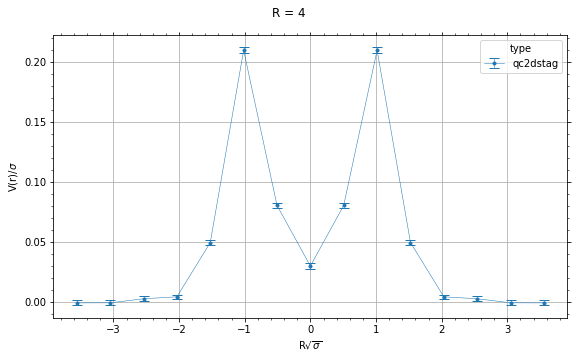

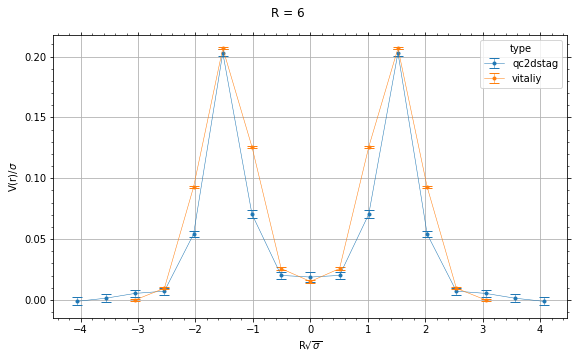

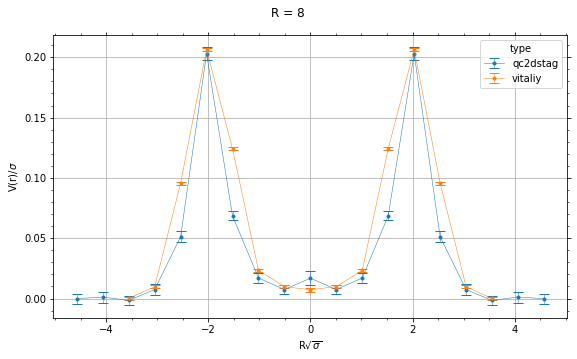

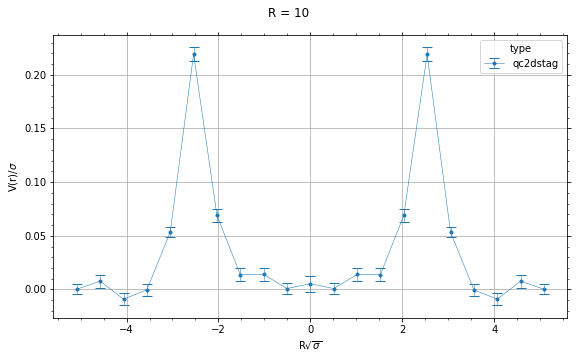

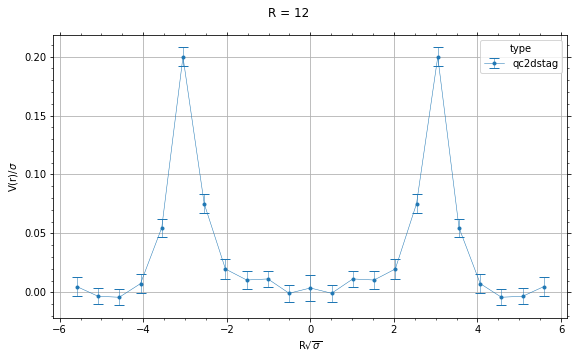

In [7]:
test_flux('../result/flux_tube_wilson/vitaliy/beta2.6/act-lng-prof0.dat', remove_spaces, '../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6', {'su2': 6}, 0.258265528440037, 'su2')

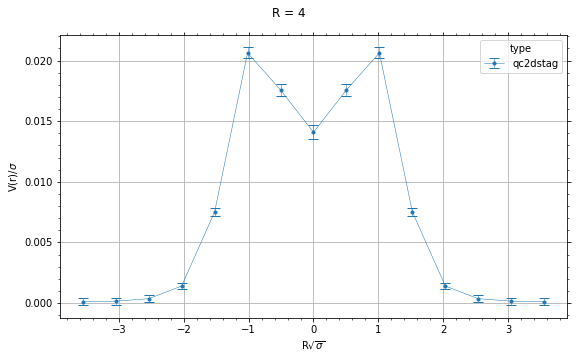

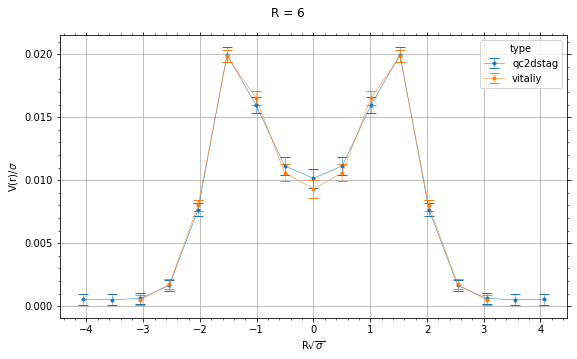

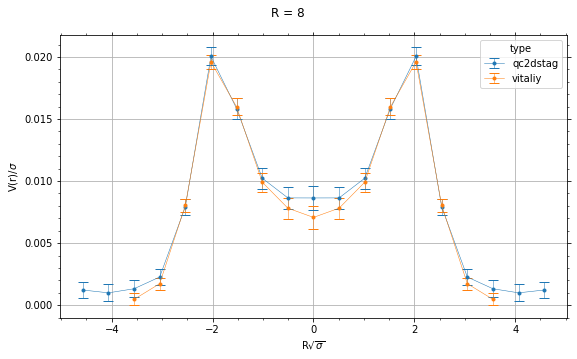

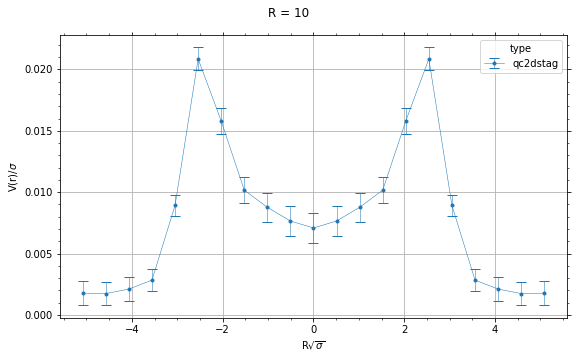

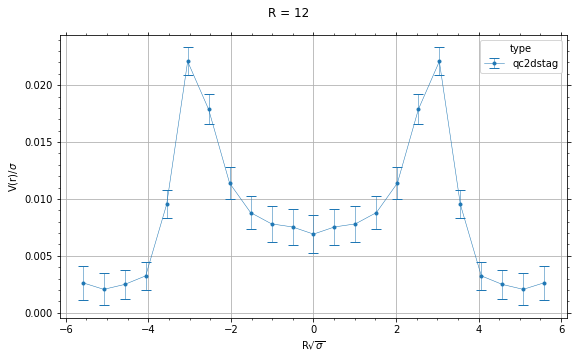

In [8]:
test_flux('../result/flux_tube_wilson/vitaliy/beta2.6/act-lng-prof0_mon.dat', remove_spaces, '../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6', {'monopole': 10}, 0.258265528440037, 'monopole')

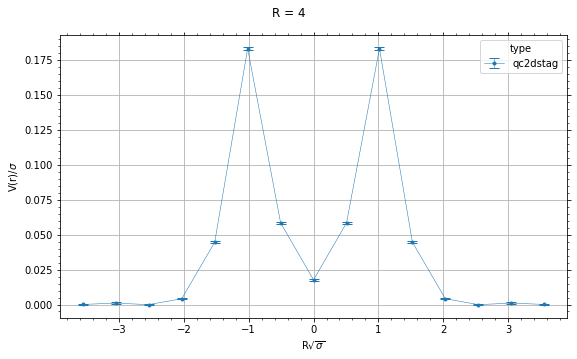

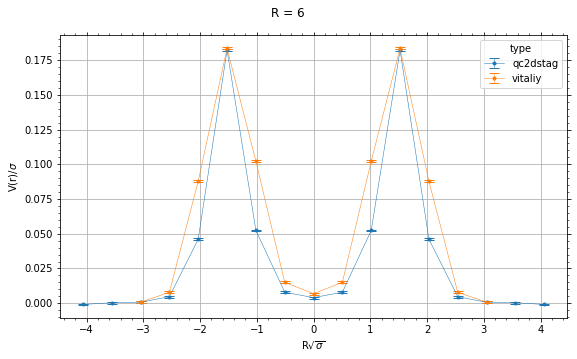

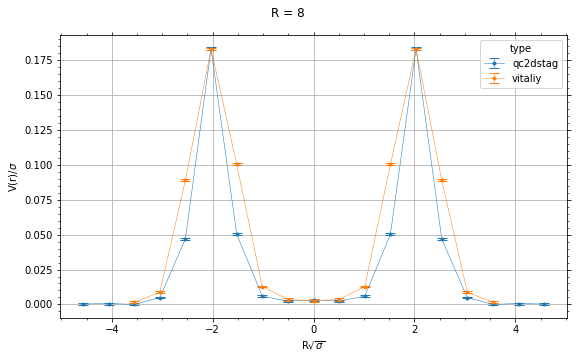

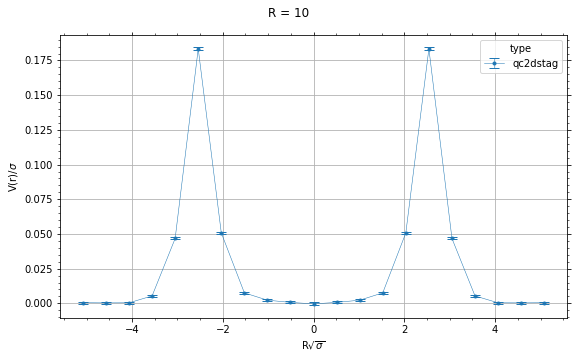

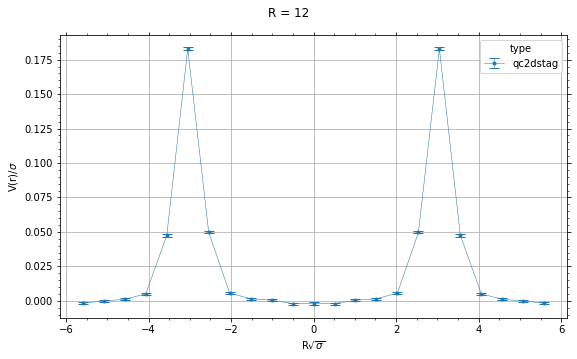

In [9]:
test_flux('../result/flux_tube_wilson/vitaliy/beta2.6/act-lng-prof0-off.dat', remove_spaces, '../result/flux_tube_wilson/su2/su2_suzuki/24^4/beta2.6', {'monopoless': 4}, 0.258265528440037, 'monopoless')

In [100]:
def sum_vitaliy(data):
    data[f'err_action_mon+mod'] = data.apply(lambda x: math.sqrt(x[f'err_action_mon'] ** 2 + x[f'err_action_mod'] ** 2), axis = 1)
    data[f'field_action_mon+mod'] = data.apply(lambda x: x[f'field_action_mon'] + x[f'field_action_mod'], axis = 1)

    return data


def join_back_vitaliy(data, flux_coord, columns):
    data1 = []
    for matrix_type in ['su2', 'mon', 'mod', 'mon+mod']:
        data1.append(data[[flux_coord, 'R', f'field_action_{matrix_type}', f'err_action_{matrix_type}'] + columns])
        data1[-1] = data1[-1].rename(columns={f'field_action_{matrix_type}': 'field', f'err_action_{matrix_type}': 'err'})
        data1[-1]['matrix_type'] = matrix_type

    return pd.concat(data1)

def plot_flux_vitaliy(data, image_path, flux_coord):
    R = data['R'].iloc[0]
    fg = seaborn.FacetGrid(data=data, hue = 'matrix_type', height=5, aspect=1.4, legend_out=False, hue_kws={"ls" : ['-', '', '', '-']})
    fg.fig.suptitle(f'flux decomposition')
    fg.map(plt.errorbar, flux_coord, 'field', 'err', mfc=None, fmt='o', ms = 3, capsize = 5, lw = 0.5
    ).add_legend()
    # plt.legend(loc='upper left')
    if flux_coord == 'x_tr':
        coord_sign = r"$x_{\perp}$"
    elif flux_coord == 'd':
        coord_sign = r"$x_{\parallel}$"
    else:
        coord_sign = "wrong flux_coord"
    
    fg.ax.set_xlabel(coord_sign + r"$\sqrt{\sigma}$")
    fg.ax.set_ylabel(r"$\mathcal{L}$/$\sigma^{2}$")
    fg.ax.spines['right'].set_visible(True)
    fg.ax.spines['top'].set_visible(True)
    fg.ax.minorticks_on()
    fg.ax.tick_params(which = 'both', bottom = True, top = True, left = True, right = True)
    plt.grid(dash_capstyle = 'round')

    plt.show()
    save_image(image_path, f'flux_R={R}', fg)

def read_data_long(path, sigma):
    data = []
    data.append(read_file_vitaliy(f'{path}/act-lng-prof0.dat', remove_spaces, 'su2', 'd'))
    data[-1]['d'] = data[-1]['d'] * math.sqrt(sigma)
    data[-1][f"field_action_su2"] = data[-1][f"field_action_su2"] / sigma**2
    data[-1][f"err_action_su2"] = data[-1][f"err_action_su2"] / sigma**2
    data.append(read_file_vitaliy(f'{path}/act-lng-prof0_mon.dat', remove_spaces, 'mon', 'd'))
    data[-1]['d'] = data[-1]['d'] * math.sqrt(sigma)
    data[-1][f"field_action_mon"] = data[-1][f"field_action_mon"] / sigma**2
    data[-1][f"err_action_mon"] = data[-1][f"err_action_mon"] / sigma**2
    data.append(read_file_vitaliy(f'{path}/act-lng-prof0-off.dat', remove_spaces, 'mod', 'd'))
    data[-1]['d'] = data[-1]['d'] * math.sqrt(sigma)
    data[-1][f"field_action_mod"] = data[-1][f"field_action_mod"] / sigma**2
    data[-1][f"err_action_mod"] = data[-1][f"err_action_mod"] / sigma**2

    data = pd.concat(data, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]

    return data

def flux_vitaliy_long(path, sigma, image_path):
    data = read_data_long(path, sigma)

    data = sum_vitaliy(data)

    data = join_back_vitaliy(data, 'd', [])

    # print(data)

    # data = data[data['R'] == 6]

    data.groupby(['R']).apply(plot_flux_vitaliy, image_path, 'd')

def read_data_tr(path, sigma):
    data = []
    data.append(read_file_vitaliy(f'{path}/act-lng-prof0-tr.dat', remove_spaces, 'su2', 'x_tr'))
    data[-1]['x_tr'] = data[-1]['x_tr'] * math.sqrt(sigma)
    data[-1][f"field_action_su2"] = data[-1][f"field_action_su2"] / sigma**2
    data[-1][f"err_action_su2"] = data[-1][f"err_action_su2"] / sigma**2
    data.append(read_file_vitaliy(f'{path}/act-lng-prof0-tr_mon.dat', remove_spaces, 'mon', 'x_tr'))
    data[-1]['x_tr'] = data[-1]['x_tr'] * math.sqrt(sigma)
    data[-1][f"field_action_mon"] = data[-1][f"field_action_mon"] / sigma**2
    data[-1][f"err_action_mon"] = data[-1][f"err_action_mon"] / sigma**2
    data.append(read_file_vitaliy(f'{path}/act-lng-prof0-tr-off.dat', remove_spaces, 'mod', 'x_tr'))
    data[-1]['x_tr'] = data[-1]['x_tr'] * math.sqrt(sigma)
    data[-1][f"field_action_mod"] = data[-1][f"field_action_mod"] / sigma**2
    data[-1][f"err_action_mod"] = data[-1][f"err_action_mod"] / sigma**2

    data = pd.concat(data, axis = 1)
    data = data.loc[:,~data.columns.duplicated()]

    return data

def flux_vitaliy_tr(path, sigma, image_path):
    data = read_data_tr(path, sigma)

    data = sum_vitaliy(data)

    data = join_back_vitaliy(data, 'x_tr', [])

    # print(data)

    # data = data[data['R'] == 6]

    data.groupby(['R']).apply(plot_flux_vitaliy, image_path, 'x_tr')


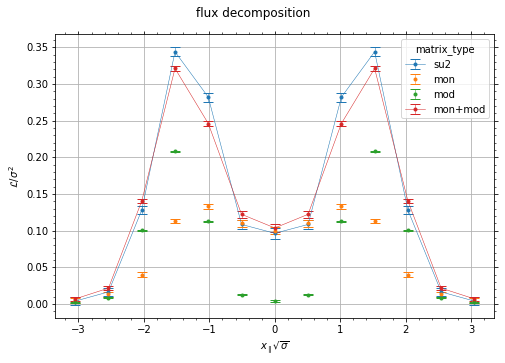

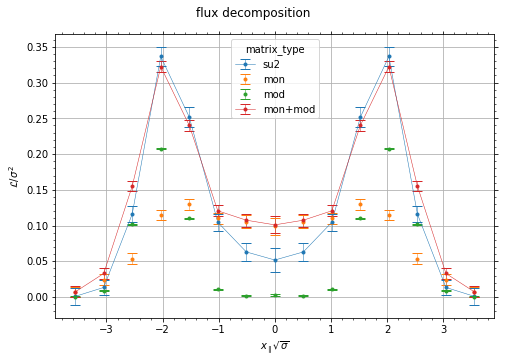

In [101]:
flux_vitaliy_long('../result/flux_tube_wilson/vitaliy/beta2.4', 0.258265528440037, '../images/flux_tube_wilson/su2_suzuki/24^4/flux_decomposition/longitudinal/beta2.4')

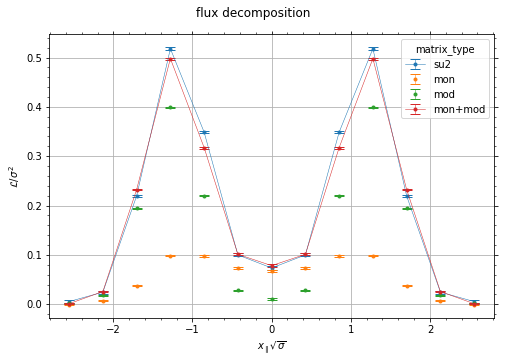

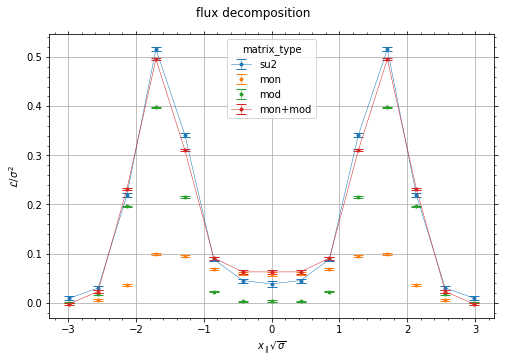

In [102]:
flux_vitaliy_long('../result/flux_tube_wilson/vitaliy/beta2.5', 0.181839887534859, '../images/flux_tube_wilson/su2_suzuki/24^4/flux_decomposition/longitudinal/beta2.5')

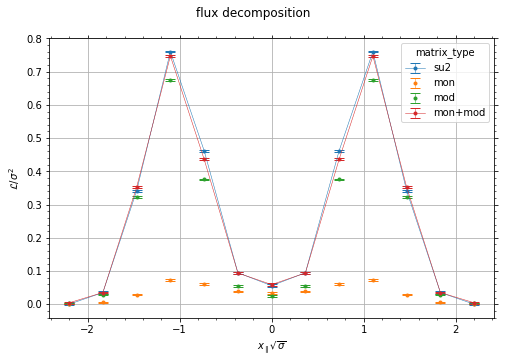

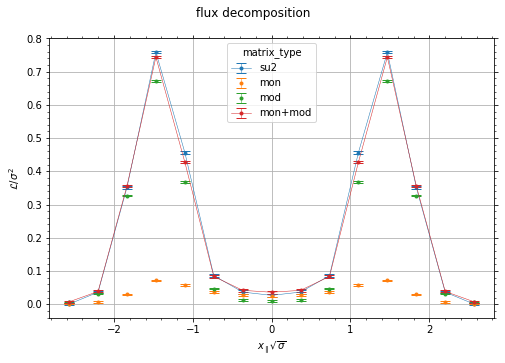

In [103]:
flux_vitaliy_long('../result/flux_tube_wilson/vitaliy/beta2.6', 0.134725276024954, '../images/flux_tube_wilson/su2_suzuki/24^4/flux_decomposition/longitudinal/beta2.6')

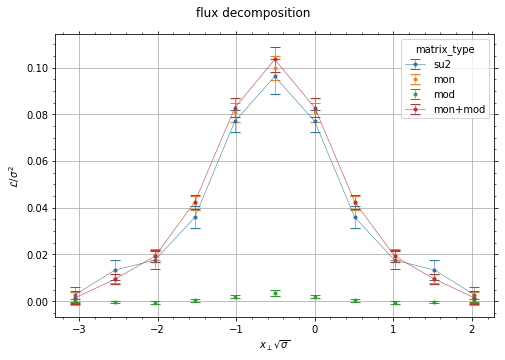

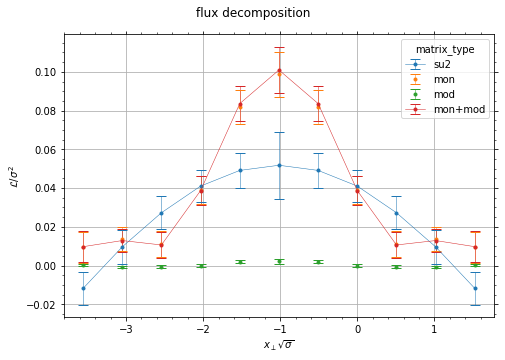

In [107]:
flux_vitaliy_tr('../result/flux_tube_wilson/vitaliy/beta2.4', 0.258265528440037, '../images/flux_tube_wilson/su2_suzuki/24^4/flux_decomposition/transversal/beta2.4')

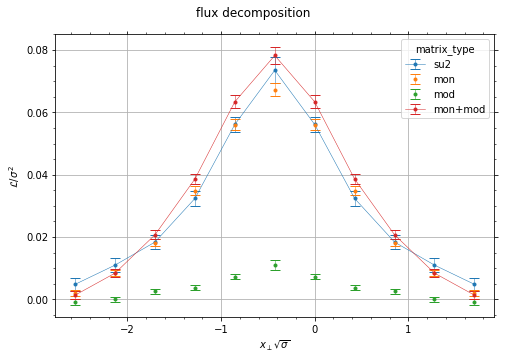

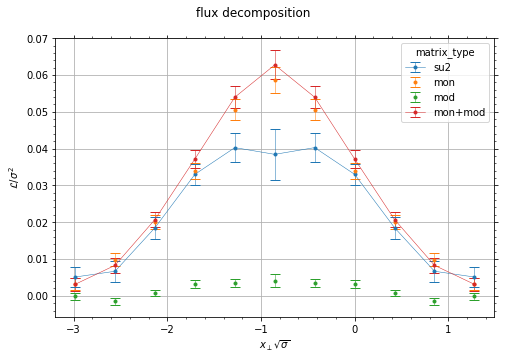

In [108]:
flux_vitaliy_tr('../result/flux_tube_wilson/vitaliy/beta2.5', 0.181839887534859, '../images/flux_tube_wilson/su2_suzuki/24^4/flux_decomposition/transversal/beta2.5')

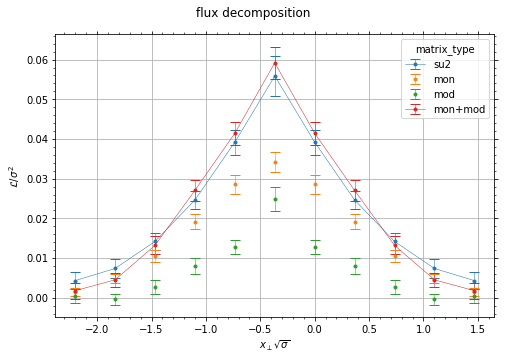

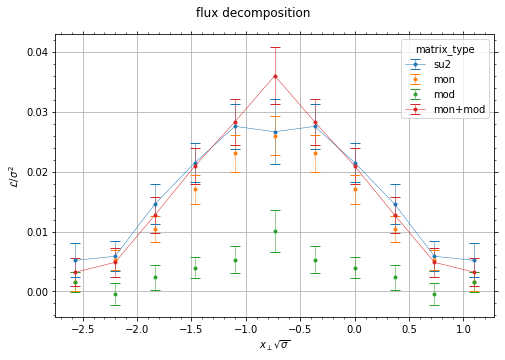

In [109]:
flux_vitaliy_tr('../result/flux_tube_wilson/vitaliy/beta2.6', 0.134725276024954, '../images/flux_tube_wilson/su2_suzuki/24^4/flux_decomposition/transversal/beta2.6')